In [67]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
!pip install geopy
#from geopy.distance import geodesic
!pip install geopandas
import geopandas as gpd
from shapely.geometry import Point, Polygon
import hvplot.pandas
!pip install scipy
import scipy.stats as stats
import cartopy.crs as ccrs


In [68]:
#reading in the csv file
staten_island_df = pd.read_csv('staten_island.csv')
staten_island_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OBJECTID     390 non-null    int64  
 1   Borough      390 non-null    object 
 2   Offense      366 non-null    object 
 3   Latitude     390 non-null    float64
 4   Longitude    390 non-null    float64
 5   Public Area  24 non-null     object 
dtypes: float64(2), int64(1), object(3)
memory usage: 18.4+ KB


In [69]:
staten_island_df.head()

,OBJECTID,Borough,Offense,Latitude,Longitude,Public Area
0,1,Staten Island,ROBBERY,40.643566,-74.074001,NaN
1,2,Staten Island,ROBBERY,40.635961,-74.161365,NaN
2,3,Staten Island,ROBBERY,40.643569,-74.098338,NaN
3,4,Staten Island,ROBBERY,40.630408,-74.142977,NaN
4,5,Staten Island,ROBBERY,40.630539,-74.076641,NaN


In [70]:
#dividing the df into crimes and public institutions
#the letter r here is used as the official abbreviation for staten island

# crimes df
crimes = staten_island_df.iloc[0:365, :]
offense_df = crimes.drop(columns= ["Borough", "Public Area"])
offense_df.head()

,OBJECTID,Offense,Latitude,Longitude
0,1,ROBBERY,40.643566,-74.074001
1,2,ROBBERY,40.635961,-74.161365
2,3,ROBBERY,40.643569,-74.098338
3,4,ROBBERY,40.630408,-74.142977
4,5,ROBBERY,40.630539,-74.076641


In [71]:
crimes.head()

,OBJECTID,Borough,Offense,Latitude,Longitude,Public Area
0,1,Staten Island,ROBBERY,40.643566,-74.074001,NaN
1,2,Staten Island,ROBBERY,40.635961,-74.161365,NaN
2,3,Staten Island,ROBBERY,40.643569,-74.098338,NaN
3,4,Staten Island,ROBBERY,40.630408,-74.142977,NaN
4,5,Staten Island,ROBBERY,40.630539,-74.076641,NaN


In [72]:
# public institutions df
public = staten_island_df.iloc[366:389, :]
public_area_df = public.drop(columns= ["Borough", "Offense"])
public_area_df.head()

,OBJECTID,Latitude,Longitude,Public Area
366,367,40.614533,-74.074185,PARKS
367,368,40.510392,-74.230405,RECREATION AND WATERFRONT SITES
368,369,40.595802,-74.063027,PUBLIC LIBRARIES
369,370,40.590395,-74.101138,PUBLIC LIBRARIES
370,371,40.638748,-74.083899,PARKS


In [73]:
# finding the crimes that occured near public institions
#each locations a crime took place, converted into a geodataframe
crimes_gdf = gpd.GeoDataFrame(
    crimes,
    geometry=gpd.points_from_xy(
        crimes["Latitude"],
        crimes["Longitude"],
    ),
    crs="EPSG:4326",
)

# each public institution

public_gdf = gpd.GeoDataFrame(
    public, 
    geometry=gpd.points_from_xy(
        public["Latitude"],
        public["Longitude"],
    ),
    crs="EPSG:4326",
)

# EPSG:3857 converts geometry points to meters

crimes_gdf = crimes_gdf.to_crs(3857)
public_gdf = public_gdf.to_crs(3857)

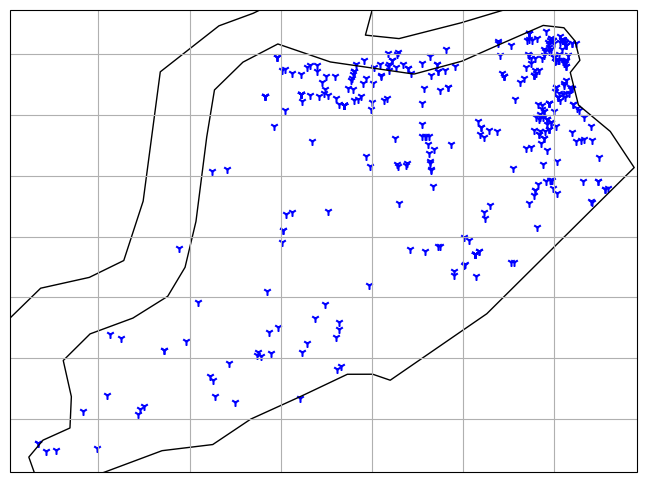

In [74]:
latitude_column = 'Latitude'
longitude_column = 'Longitude'

# Create a new figure
plt.figure(figsize=(10, 6))

# Define the projection you want to use (e.g., PlateCarree, Mercator, etc.)
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features such as coastlines, rivers, etc.
ax.coastlines()

# Plot points from the DataFrame
ax.scatter(staten_island_df[longitude_column], staten_island_df[latitude_column], color='blue', marker='1', transform=ccrs.PlateCarree())

# Add gridlines
ax.gridlines()

# Show the plot
plt.show()

In [75]:
# put public areas in a list
#thos portion of code returns all crimes commited within 1609 meters of a public institution
    # 1 miles would be 1609 meters

x = public_gdf.buffer(1609).unary_union

crimes_per = crimes_gdf["geometry"].intersection(x)

# print all the nearby points
all_crimes_near_pi = (crimes_gdf[~crimes_per.is_empty])
all_crimes_near_pi

,OBJECTID,Borough,Offense,Latitude,Longitude,Public Area,geometry
1,2,Staten Island,ROBBERY,40.635961,-74.161365,NaN,POINT (4523574.486 -12581036.663)
5,6,Staten Island,ROBBERY,40.637135,-74.123473,NaN,POINT (4523705.178 -12565599.692)
6,7,Staten Island,ROBBERY,40.643996,-74.076502,NaN,POINT (4524468.939 -12546513.640)
8,9,Staten Island,ROBBERY,40.634941,-74.086335,NaN,POINT (4523460.941 -12550504.598)
10,11,Staten Island,ROBBERY,40.636810,-74.118650,NaN,POINT (4523668.997 -12563637.356)
...,...,...,...,...,...,...,...
351,352,Staten Island,ROBBERY,40.643220,-74.075921,NaN,POINT (4524382.555 -12546277.902)
353,354,Staten Island,ROBBERY,40.643996,-74.076502,NaN,POINT (4524468.939 -12546513.640)
354,355,Staten Island,ROBBERY,40.645288,-74.085547,NaN,POINT (4524612.763 -12550184.681)
359,360,Staten Island,ROBBERY,40.644719,-74.081327,NaN,POINT (4524549.423 -12548471.682)


In [76]:
# find control
#this for loop returns a dataframe of the sum of each offense committed by each public institution

#create empty list to hold the number of crimes commited within a 1 mile radius of each public institution
crimes_per_location = []

# Define the radius in meters
radius = 1609 # about 1 mile

for offense in crimes_gdf["Offense"]:
    crimes_per_location = []
    crimes_gdf_each = crimes_gdf[crimes_gdf["Offense"] == offense]

    for i in range(len(public_gdf)):

        # Calculate the distances between all pairs of points
        distances = gpd.GeoSeries(crimes_gdf_each.geometry).distance(public_gdf.geometry.iloc[i])

        # Filter the pairs where the distance is within the radius
        within_radius = distances <= radius

        # Count the number of points within the radius for each point in gdf2
        count_within_radius = within_radius.sum()

        crimes_per_location.append(count_within_radius)
    public_gdf[offense] = crimes_per_location

In [77]:
#creating a column for the sum amount of offenses
public_gdf["Total Crimes"] = public_gdf[['ROBBERY','MURDER', 'RAPE']].sum(axis=1)
public_gdf

,OBJECTID,Borough,Offense,Latitude,Longitude,Public Area,geometry,ROBBERY,MURDER,RAPE,MURDER,Total Crimes
366,367,Staten Island,NaN,40.614533,-74.074185,PARKS,POINT (4521189.101 -12545573.503),10,1,0,0,11
367,368,Staten Island,NaN,40.510392,-74.230405,RECREATION AND WATERFRONT SITES,POINT (4509596.170 -12609255.973),0,0,0,0,0
368,369,Staten Island,NaN,40.595802,-74.063027,PUBLIC LIBRARIES,POINT (4519103.997 -12541048.240),5,0,0,0,5
369,370,Staten Island,NaN,40.590395,-74.101138,PUBLIC LIBRARIES,POINT (4518502.095 -12556517.429),2,0,0,0,2
370,371,Staten Island,NaN,40.638748,-74.083899,PARKS,POINT (4523884.728 -12549515.585),24,0,0,0,24
371,372,Staten Island,NaN,40.636564,-74.160471,PARKS,POINT (4523641.579 -12580672.111),4,1,0,0,5
372,373,Staten Island,NaN,40.576267,-74.203381,PRESERVES AND CONSERVATION AREAS,POINT (4516929.352 -12598196.087),0,0,0,0,0
373,374,Staten Island,NaN,40.608690,-74.119578,PARKS,POINT (4520538.708 -12564014.907),10,0,0,0,10
374,375,Staten Island,NaN,40.639297,-74.120934,CEMETERIES,POINT (4523945.891 -12564566.701),6,1,0,0,7
375,376,Staten Island,NaN,40.526901,-74.163615,GARDENS,POINT (4511433.992 -12581954.507),0,0,0,0,0


In [66]:
#there are 7 types of public areas
#should I group gardens, parks, conservation, and waterfront sites under one heading for simplicity?
#public libraries and malls are two distinct areas from the other 5

reduced_public_gdf = public_gdf
reduced_public_gdf["Public Area"] = reduced_public_gdf["Public Area"].replace(
       ['PARKS', 'RECREATION AND WATERFRONT SITES',
        'PRESERVES AND CONSERVATION AREAS', 'CEMETERIES', 'GARDENS'],
        "Parks and Other Outdoor Areas"
)

reduced_public_gdf

,OBJECTID,Borough,Offense,Latitude,Longitude,Public Area,geometry
366,367,Staten Island,NaN,40.614533,-74.074185,Parks and Other Outdoor Areas,POINT (4521189.101 -12545573.503)
367,368,Staten Island,NaN,40.510392,-74.230405,Parks and Other Outdoor Areas,POINT (4509596.170 -12609255.973)
368,369,Staten Island,NaN,40.595802,-74.063027,PUBLIC LIBRARIES,POINT (4519103.997 -12541048.240)
369,370,Staten Island,NaN,40.590395,-74.101138,PUBLIC LIBRARIES,POINT (4518502.095 -12556517.429)
370,371,Staten Island,NaN,40.638748,-74.083899,Parks and Other Outdoor Areas,POINT (4523884.728 -12549515.585)
371,372,Staten Island,NaN,40.636564,-74.160471,Parks and Other Outdoor Areas,POINT (4523641.579 -12580672.111)
372,373,Staten Island,NaN,40.576267,-74.203381,Parks and Other Outdoor Areas,POINT (4516929.352 -12598196.087)
373,374,Staten Island,NaN,40.608690,-74.119578,Parks and Other Outdoor Areas,POINT (4520538.708 -12564014.907)
374,375,Staten Island,NaN,40.639297,-74.120934,Parks and Other Outdoor Areas,POINT (4523945.891 -12564566.701)
375,376,Staten Island,NaN,40.526901,-74.163615,Parks and Other Outdoor Areas,POINT (4511433.992 -12581954.507)


In [96]:
r_summary_stats = reduced_public_gdf.groupby("Public Area")[['ROBBERY',  'RAPE', 'Total Crimes']].describe()
r_summary_stats["ROBBERY"]

,count,mean,std,min,25%,50%,75%,max
Public Area,,,,,,,,
PUBLIC LIBRARIES,4.0,2.500000,1.732051,1.0,1.75,2.0,2.75,5.0
Parks and Other Outdoor Areas,18.0,8.111111,11.034112,0.0,0.25,4.5,9.75,41.0
"STREETSCAPES, PLAZAS, AND MALLS",1.0,5.000000,NaN,5.0,5.00,5.0,5.00,5.0


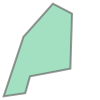

In [97]:
# Coordinates for the polygon of staten island
# Coordinates determined by HeadWall photonics (http://apps.headwallphotonics.com)

staten_island_poly = Polygon([
    (40.5004753162685, -74.24873416273303),
    (40.54484131402899, -74.24221103040881),
    (40.554754403637595, -74.20753543226428),
    (40.6379143073708, -74.19174258558459),
    (40.64130107521177, -74.07844607679553),
    (40.60195187161857, -74.05784671156115),
    (40.5411887532192, -74.1261679395885)
])
staten_island_poly

In [98]:
# Defining the randomization generator
#code adjusted from online source published by Ayush Sethi

def polygon_random_points (poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
            random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
            if (random_point.within(poly)):
                points.append(random_point)
    return points

In [99]:
# Choose the number of points desired. This method uses 100 points. 
points = polygon_random_points(staten_island_poly, 100)
# Printing the results.
for p in points:
    print(p.x,",",p.y)

40.518403055966594 , -74.23148807489723
40.63582332429497 , -74.10405569249978
40.56259018860098 , -74.14367321272192
40.61243352619601 , -74.15935731915101
40.5862181057403 , -74.08181029525326
40.596699189955494 , -74.14737374596972
40.5064830707901 , -74.2323121287973
40.53814513406544 , -74.18870907194392
40.580892398942034 , -74.15640800076001
40.635285930129136 , -74.1531924967595
40.53859520619448 , -74.23065670579889
40.611631343517175 , -74.183638223587
40.60496790580667 , -74.13334903852706
40.618923871592344 , -74.12727731695558
40.554996747131135 , -74.15659804632008
40.578947270698286 , -74.16731029440739
40.58598142536506 , -74.16666353478614
40.59577047212104 , -74.10015501566883
40.5219735517214 , -74.19771912076732
40.52651674005099 , -74.18772556698076
40.56880524933529 , -74.19086559100383
40.55449351866222 , -74.147780217954
40.56070588485302 , -74.19503446682653
40.623860762517346 , -74.07456201299753
40.55100327697836 , -74.21593886349348
40.54669125832554 , -74.1

In [100]:
#creating a gdf out of the random points
r_random_gdf = gpd.GeoDataFrame(points,
                                geometry= points,
                                crs= "EPSG:4326")
#this step is for mapping later
r_random_gdf['Latitude'] = r_random_gdf['geometry'].x
r_random_gdf['Longitude'] = r_random_gdf['geometry'].y

#converting to meters
r_random_gdf = r_random_gdf.to_crs(3857)
r_random_gdf.head()

,0,geometry,Latitude,Longitude
0,POINT (40.518403055966594 -74.23148807489723),POINT (4510487.996 -12609699.622),40.518403,-74.231488
1,POINT (40.63582332429497 -74.10405569249978),POINT (4523559.160 -12557703.035),40.635823,-74.104056
2,POINT (40.56259018860098 -74.14367321272192),POINT (4515406.885 -12573824.642),40.562590,-74.143673
3,POINT (40.61243352619601 -74.15935731915101),POINT (4520955.420 -12580217.841),40.612434,-74.159357
4,POINT (40.5862181057403 -74.08181029525326),POINT (4518037.133 -12548667.840),40.586218,-74.081810
